In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import shap
import math
import matplotlib.pyplot as plt
from scipy import stats


from combat.pycombat import pycombat
from xgboost import XGBClassifier

# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, RandomizedSearchCV, LearningCurveDisplay, learning_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, f1_score, make_scorer, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [2]:
os.getcwd()

'c:\\Users\\samue\\OneDrive\\Documenti\\Studio\\Università\\Tesi\\Progetto\\Ricerca\\Script\\Microarray_Script\\DatasetFull'

In [3]:
# os.chdir('../store/DatasetFull')
os.chdir("../../../SYMBOL/Results/DatasetFull")

<h2>Preparazione dei dati</h2>

In [4]:
dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombat_symbol.csv')
sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
dataset

,SampleID,PatientID,Label,TRAK2,MARCHF5,AVIL,CLSTN1,TAPBPL,TRIM38,GDF11,...,TKT,PAK1IP1,NDUFA1,PEX7,NET1,TMED5,FADD,URGCP,MDM4,BMPR1A
0,0-GSM1026056_600009.0001,0-600009.0001,1,9.597071,6.172613,6.183003,7.619254,8.451946,9.674435,6.629841,...,11.264573,7.339375,10.188925,6.535162,7.816546,9.744325,8.263995,7.352167,8.662674,6.263145
1,0-GSM1026057_600009.0001-FollowUp_1,0-600009.0001,1,9.039251,6.532620,6.350718,7.841904,8.629886,9.565077,6.824635,...,11.293242,7.251840,10.255465,6.432247,7.916046,9.687447,8.241698,7.349809,8.445578,7.242537
2,0-GSM1026058_41461.0001,0-41461.0001,1,8.791386,6.548371,6.933703,7.279164,8.166420,9.772884,6.515736,...,11.377160,7.279236,10.101372,6.495679,8.104559,9.632676,8.242744,7.205897,8.071700,6.124447
3,0-GSM1026059_41462.0001,0-41462.0001,1,9.373170,7.116801,7.012218,7.233344,8.338171,9.725869,6.458866,...,11.373784,7.311252,10.314306,6.353293,7.386301,9.769748,8.376067,7.312015,8.425182,6.534315
4,0-GSM1026060_600029.0001,0-600029.0001,1,9.076237,7.104757,6.515409,7.488312,8.355218,10.033820,6.189225,...,11.263786,7.289160,10.243407,6.334131,7.331289,9.626407,8.217957,7.254979,7.917974,6.195773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,7-GSM545842_M10,7-M10,1,8.955028,6.642111,6.639887,7.445428,8.359939,9.682368,6.735513,...,11.589049,7.015461,10.312671,5.698647,7.380776,9.698418,8.155223,7.361099,8.327890,6.361955
1034,7-GSM545843_M11,7-M11,1,9.101329,6.715089,6.611748,7.449074,8.112262,9.634445,6.503292,...,11.215584,7.259678,10.357670,6.671623,7.428976,9.763741,8.122246,7.262578,8.175908,7.282642
1035,7-GSM545844_M11-FollowUp_1,7-M11,1,9.271382,6.670915,6.620238,7.404586,8.119619,9.650254,6.681918,...,11.213354,7.351145,10.208762,6.715863,7.705067,9.785031,8.103883,7.362873,8.131763,7.425195
1036,7-GSM545845_M12,7-M12,1,9.351712,6.679360,6.581669,7.442222,8.282929,9.638524,6.409742,...,11.254584,7.178289,10.401224,6.861365,7.413546,9.703183,8.135620,7.244212,8.187447,6.908857


In [10]:
print(list(dataset.columns))

['SampleID', 'PatientID', 'Label', 'TRAK2', 'MARCHF5', 'AVIL', 'CLSTN1', 'TAPBPL', 'TRIM38', 'GDF11', 'TBXA2R', 'SPAST', 'MCM3', 'OSBP', 'SLC50A1', 'USP1', 'ZNF222', 'ATG3', 'ZFPL1', 'ERP44', 'HAPSTR1', 'TMSB15B', 'EHMT1', 'BPI', 'ABHD4', 'ADRA2A', 'UBB', 'SDHAF3', 'LPCAT3', 'CSTF2T', 'IFIH1', 'ANAPC1', 'FCER2', 'CEP192', 'TULP4', 'LFNG', 'MAP3K4', 'KLF7', 'TJP2', 'PLAG1', 'CD2', 'ICOSLG', 'TBL2', 'JHY', 'BCAS2', 'FBXL5', 'EMC2', 'ELK4', 'MCTP2', 'ABCF3', 'TRIM26', 'HNRNPK', 'XPC', 'CCDC6', 'CCDC85B', 'HBD', 'AP3B1', 'AASDHPPT', 'NFKBIA', 'ATP6V0B', 'PTOV1', 'OSBPL10', 'SLC25A42', 'HAGH', 'C2orf42', 'NDUFA3', 'NECTIN2', 'ZBTB17', 'NOCT', 'TGFBRAP1', 'TMEM115', 'BLVRA', 'LAX1', 'IL15', 'KARS1', 'FKBP2', 'GAS7', 'INPPL1', 'PIP5K1B', 'TBKBP1', 'NDUFAF7', 'GCLC', 'PRSS23', 'CD248', 'PTDSS2', 'EFHD2', 'PLA2G4C', 'IL13RA1', 'ADGRL1', 'FHOD1', 'MRPL22', 'MAF', 'COASY', 'ZNF580', 'YARS2', 'RAB14', 'EMC10', 'PTBP1', 'RXRA', 'RPRD1A', 'ARPC4', 'AAMP', 'MAPK4', 'UTP6', 'ANKRD53', 'AMZ2', 'STK39',

<h2>Analisi di correlazione</h2>

In [ ]:
current = dataset.copy()
data = current.drop(['SampleID', 'PatientID', 'Label'], axis=1)
dataCorr = data.corr()

# joblib.dump(dataCorr, '../Results/dataFullCorr.pkl')

In [6]:
dataCorr = joblib.load('dataFullCorr.pkl')
dataCorr

,TRAK2,MARCHF5,AVIL,CLSTN1,TAPBPL,TRIM38,GDF11,TBXA2R,SPAST,MCM3,...,TKT,PAK1IP1,NDUFA1,PEX7,NET1,TMED5,FADD,URGCP,MDM4,BMPR1A
TRAK2,1.000000,-0.021471,-0.036611,0.070925,-0.060041,0.026626,-0.054771,-0.015266,0.161515,0.110674,...,-0.136496,0.251084,0.101332,0.177012,0.076570,0.200383,0.065285,0.048478,0.018069,0.146992
MARCHF5,-0.021471,1.000000,0.176014,-0.146238,-0.068889,0.102469,-0.068633,-0.377817,0.358772,-0.019076,...,0.053966,0.139673,0.161421,0.159038,-0.117374,0.247420,-0.014945,-0.075943,0.260618,0.257423
AVIL,-0.036611,0.176014,1.000000,-0.050519,0.027393,0.085734,0.073418,0.001100,0.175759,0.076288,...,0.092523,0.025801,0.063104,-0.049276,-0.037546,-0.060807,0.033368,0.103062,0.099836,0.019719
CLSTN1,0.070925,-0.146238,-0.050519,1.000000,0.059742,0.056467,-0.085055,-0.103806,-0.015975,0.189461,...,0.050432,0.065682,0.015981,-0.004850,-0.193266,0.044974,-0.036655,0.156160,0.113253,0.101455
TAPBPL,-0.060041,-0.068889,0.027393,0.059742,1.000000,-0.088500,0.051811,-0.084005,-0.086631,0.099271,...,0.062286,0.018102,0.013149,-0.075881,-0.056024,-0.069561,0.244852,0.167433,0.067642,-0.084085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMED5,0.200383,0.247420,-0.060807,0.044974,-0.069561,-0.007725,-0.137417,-0.276778,0.509345,-0.006102,...,0.011890,0.222317,0.097390,0.211155,-0.032221,1.000000,0.203710,-0.257453,0.129233,0.202255
FADD,0.065285,-0.014945,0.033368,-0.036655,0.244852,-0.098666,-0.053680,-0.031436,-0.052119,0.016686,...,0.065938,0.171291,0.094952,-0.038464,-0.042736,0.203710,1.000000,0.177754,-0.003622,-0.062669
URGCP,0.048478,-0.075943,0.103062,0.156160,0.167433,0.118428,0.107182,-0.033894,-0.274693,0.161965,...,0.073655,0.101975,-0.006559,-0.175108,-0.038309,-0.257453,0.177754,1.000000,0.133718,0.032313
MDM4,0.018069,0.260618,0.099836,0.113253,0.067642,0.193929,-0.131465,-0.349414,0.246574,0.109626,...,0.050024,0.081873,0.017931,-0.009883,-0.234382,0.129233,-0.003622,0.133718,1.000000,0.206420


In [ ]:
clusters = []
for i in range(0, dataCorr.shape[0]):
    cluster = []
    gene_i = dataCorr.index[i]
    print(i)
    for j in range(0, dataCorr.shape[1]):
        gene_j = dataCorr.columns[j]
        if abs(dataCorr.loc[gene_i, gene_j]) >= 0.9:
            cluster.append(gene_j)
    if len(cluster) > 1:
        clusters.append(cluster)

# joblib.dump(clusters, "../Results/clustersFull.pkl")

In [7]:
clusters = joblib.load("clustersFull.pkl")
print(clusters)

gene_list = list(dataset.columns)
print(len(gene_list))

for cluster in clusters:
    for gene in cluster:
        if gene in gene_list:
            gene_list.remove(gene)

print(len(gene_list))

[['DDX3Y', 'UTY'], ['EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY'], ['EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY'], ['EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY'], ['DDX3Y', 'EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY'], ['EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY']]
6676
6670


In [8]:
current = dataset.copy()
data = current.drop(['SampleID', 'PatientID', 'Label'], axis=1)
representative = {}

for cluster in clusters:
    representative[tuple(cluster)] = ""
    variances = {}
    for var in cluster:
        variances[var] = data[var].var()

    sorted_variances = sorted(variances.items(), key=lambda item: item[1])
    reprs = sorted_variances.pop()[0]
    if reprs not in representative.values():
        representative[tuple(cluster)] = reprs
    else:
        while reprs in representative.values() and sorted_variances != []:
            reprs = sorted_variances.pop()[0]
                
        representative[tuple(cluster)] = reprs

sorted_repr = dict(sorted(representative.items(), key=lambda x: len(x[0])))
cluster_sorted = list(sorted_repr.keys())
unique_clusters = {}
flag=True

for i in range(0, len(cluster_sorted)):
    for j in range(i+1, len(cluster_sorted)):
        if set(cluster_sorted[i]).issubset(set(cluster_sorted[j])):
            flag=False
            break
    if flag==True:
        unique_clusters[cluster_sorted[i]] = sorted_repr[cluster_sorted[i]]
    else:
        flag = True

print(unique_clusters)

{('DDX3Y', 'EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY'): 'EIF1AY'}


In [10]:
for gene in list(unique_clusters.values()):
    if gene not in gene_list:
        gene_list.append(gene)

print(len(gene_list))

6671


In [ ]:
datasetDeclustered = dataset[gene_list]
# datasetDeclustered.to_csv(path+"Dataset/MergedDatasetFullCombatDeclustered_symbol.csv", index=False)
datasetDeclustered

<h2>Divisione in train e test</h2>

In [5]:
dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombatDeclustered_symbol.csv')

gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Dataset di train:
(772, 6671)
I malati sono:  510
I sani sono:  262

Dataset di test:
(266, 6671)
I malati sono:  166
I sani sono:  100


<h1>Addestramento modello</h1>

In [14]:
def prettyPrint(model, name, test=False):
    print(name + ":")
    print("Iperparametri: ", model.best_params_)
    print("Train f1: ", model.score(x_train, y_train))
    print("Mean f1 cross-validated: ", model.best_score_)
    best_index = model.best_index_
    print("\t\t precision \t\t recall \t\t f1-score")
    print(f"0 \t\t {model.cv_results_['mean_test_precision 0'][best_index]:.2f} \t\t\t {model.cv_results_['mean_test_recall 0'][best_index]:.2f}") 
    print(f"1 \t\t {model.cv_results_['mean_test_precision 1'][best_index]:.2f} \t\t\t {model.cv_results_['mean_test_recall 1'][best_index]:.2f}")
    print(f"Accuracy \t\t\t\t\t\t\t {model.cv_results_['mean_test_Accuracy'][best_index]:.2f}")
    print(f"macro avg \t {(model.cv_results_['mean_test_precision 0'][best_index] + model.cv_results_['mean_test_precision 1'][best_index]) / 2:.2f} \t\t\t {(model.cv_results_['mean_test_recall 0'][best_index] + model.cv_results_['mean_test_recall 1'][best_index])/2:.2f} \t\t\t {model.cv_results_['mean_test_f1'][best_index]:.2f}")
    if test:  
        print("\nTest f1 score: ", model.score(x_test, y_test))
        print(classification_report(y_test, model.predict(x_test)), "\n\n")

def randomSearch(pipeline, hyperparameters, iteration, scorer, njobs, x_train, y_train):
    randomSearchResult=RandomizedSearchCV(pipeline, param_distributions=hyperparameters, n_iter=iteration, scoring=scorer, cv=5, verbose=1, random_state=42, n_jobs=njobs, refit='f1')
    randomSearchResult.fit(x_train, y_train)
    print("Best model:", randomSearchResult.best_params_)
    return randomSearchResult

def trainModel(pipeline, hyperparameters, scorer, njobs, x_train, y_train): 
    gridSearch = GridSearchCV(pipeline, param_grid=hyperparameters, cv=5, return_train_score=True, scoring=scorer, refit='f1', n_jobs=njobs, verbose=1, error_score='raise')
    gridSearch.fit(x_train, y_train)
    print("Best model:", gridSearch.best_params_)
    return gridSearch

def bayesianOpt(pipeline, hyperparameters, iteration, scorer, njobs, x_train, y_train):
    bayesianSearchResult = BayesSearchCV(estimator = pipeline, search_spaces=hyperparameters, cv=5, n_iter=iteration, return_train_score=True,  refit='f1', scoring=scorer, n_jobs=njobs, verbose=1)
    bayesianSearchResult.fit(x_train, y_train)
    print("Iperparametri:", bayesianSearchResult.best_params_)
    return bayesianSearchResult

In [8]:
pipeline = Pipeline(steps=[('scaling', MinMaxScaler()), ('smote', SMOTE(random_state=42, sampling_strategy=400/510, k_neighbors=5)), ('classifier', XGBClassifier(random_state=42))])

def precision_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[0]

def precision_class_1(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[1]

def recall_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[0]

def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[1]

scorer = {
    'Accuracy': 'accuracy',
    'precision 0': make_scorer(precision_class_0),
    'precision 1': make_scorer(precision_class_1),
    'recall 0': make_scorer(recall_class_0),
    'recall 1': make_scorer(recall_class_1),
    'f1': make_scorer(f1_score, average='macro')
}

<h3>Bayesian Hyperparameter Optimization</h3>

In [ ]:
param_dist = {
    'classifier__n_estimators': Integer(50, 600),  # Numero di alberi
    'classifier__max_depth': Integer(2, 15),  # Profondità dell'albero
    'classifier__learning_rate': Real(0.001, 1, prior='log-uniform'),  # Tasso di apprendimento
    'classifier__gamma': Real(0.0001, 100, prior='log-uniform'),  # Minimum loss reduction
    'classifier__min_child_weight': Integer(1, 10), 
    'classifier__reg_alpha': Real(0.0001, 100, prior='log-uniform'),  # Regolarizzazione L1
    'classifier__reg_lambda': Real(0.0001, 100, prior='log-uniform'),  # Regolarizzazione L2
    'classifier__scale_pos_weight': Categorical([1, 400/510])
}

bayesianOptResult = bayesianOpt(pipeline, param_dist, 600, scorer, 10, x_train, y_train)
# joblib.dump(bayesianOptResult, "../store/bayesianOptResult_new.pkl")

In [25]:
bayesianOptResult = joblib.load("../store/DatasetFull/bayesianOptResult_new.pkl")
prettyPrint(bayesianOptResult, "Bayesian Hyperparameter", True)

Bayesian Hyperparameter:
Iperparametri:  OrderedDict([('classifier__gamma', 0.029371965511257456), ('classifier__learning_rate', 0.10656589417613414), ('classifier__max_depth', 2), ('classifier__min_child_weight', 1), ('classifier__n_estimators', 600), ('classifier__reg_alpha', 0.00805367683831743), ('classifier__reg_lambda', 0.0001), ('classifier__scale_pos_weight', 0.7843137254901961)])
Train f1:  1.0
Mean f1 cross-validated:  0.7830554773726401
		 precision 		 recall 		 f1-score
0 		 0.78 			 0.64
1 		 0.83 			 0.90
Accuracy 							 0.81
macro avg 	 0.80 			 0.77 			 0.78

Test f1 score:  0.7508397932816537
              precision    recall  f1-score   support

           0       0.79      0.57      0.66       100
           1       0.78      0.91      0.84       166

    accuracy                           0.78       266
   macro avg       0.79      0.74      0.75       266
weighted avg       0.78      0.78      0.77       266
 




<h3>Random + Grid search</h3>

In [ ]:
param_dist = {
    'classifier__n_estimators': np.linspace(50, 500, 7, dtype=int),  # Numero di alberi
    'classifier__max_depth': np.arange(2, 13),  # Profondità dell'albero
    'classifier__learning_rate': np.linspace(0.01, 0.7, 15),  # Tasso di apprendimento
    'classifier__gamma': [0, 0.1, 0.3, 0.5, 0.7, 1],  # Penalizzazione sulla complessità dell'albero
    'classifier__min_child_weight': [1, 2, 3, 4], 
    'classifier__scale_pos_weight': [1, 400/510],
    'classifier__reg_alpha': [0, 0.1, 0.5, 1, 5, 10],  # Regolarizzazione L1
    'classifier__reg_lambda': [0.1, 1, 10, 20, 50, 100]  # Regolarizzazione L2
}

randomSearchModel = randomSearch(pipeline, param_dist, 5000, scorer, 100, x_train, y_train)

# joblib.dump(randomSearchModel, "../store/randomSearchModelFull_new.pkl")

In [12]:
randomSearchModelNew = joblib.load("../store/DatasetFull/randomSearchSingleModelFull_new.pkl")
prettyPrint(randomSearchModelNew, "Gradient Boosting with random search new")

Gradient Boosting with random search new:
Iperparametri:  {'classifier__scale_pos_weight': 0.7843137254901961, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 1, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.20714285714285713, 'classifier__gamma': 0.1}
Train f1:  1.0
Mean f1 cross-validated:  0.7784030896953151
		 precision 		 recall 		 f1-score
0 		 0.77 			 0.63
1 		 0.83 			 0.90
Accuracy 							 0.81
macro avg 	 0.80 			 0.77 			 0.78


In [ ]:
params = {
   "classifier__max_depth": [2, 3, 4, 5, 6],
    "classifier__n_estimators":[160, 180, 200, 220, 240, 260],
    "classifier__learning_rate": [0.15, 0.2, 0.25, 0.3],
    'classifier__scale_pos_weight': [1, 400/510],
    'classifier__reg_lambda': [1, 5, 10, 15, 20, 25],
    'classifier__reg_alpha': [0, 0.4, 0.8, 1.2],
    'classifier__gamma': [0]
}

gradientBoostingBasedOnRandom = trainModel(pipeline, params, scorer, 100, x_train, y_train)
# joblib.dump(gradientBoostingBasedOnRandom, "../store/gradientBoostingGridBasedOnRandom_new.pkl")

params2 = {
    "classifier__max_depth": [3, 4, 5, 6, 7],
    "classifier__n_estimators":[100, 130, 160, 190, 220],
    "classifier__learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25],
    'classifier__scale_pos_weight': [400/510],
    'classifier__reg_lambda': [10, 15, 20, 25, 30],
    'classifier__reg_alpha': [0, 0.2, 0.4, 0.8, 1],
    'classifier__gamma': [0, 0.1]
}

gradientBoostingBasedOnRandom2 = trainModel(pipeline, params2, scorer, 100, x_train, y_train)
# joblib.dump(gradientBoostingBasedOnRandom2, "../store/gradientBoostingGridBasedOnRandom2_new.pkl")

params3 = {
    "classifier__max_depth": [4, 5, 6],
    "classifier__n_estimators":[130, 145, 160, 175, 190],
    "classifier__learning_rate": [0.08, 0.1, 0.13, 0.15],
    'classifier__scale_pos_weight': [400/510],
    'classifier__reg_lambda': [1, 10, 20, 30],
    'classifier__reg_alpha': [0, 0.2, 0.4, 0.6, 0.8],
    'classifier__gamma': [0, 0.1, 0.4]
}

gradientBoostingBasedOnRandom3 = trainModel(pipeline, params3, scorer, 100, x_train, y_train)
joblib.dump(gradientBoostingBasedOnRandom3, "../store/gradientBoostingGridBasedOnRandom3_new.pkl")

In [22]:
gradientBoostingBasedOnRandom = joblib.load("../store/gradientBoostingGridBasedOnRandom_new.pkl")
prettyPrint(gradientBoostingBasedOnRandom, "Gradient Boosting Grid 1")

gradientBoostingBasedOnRandom2 = joblib.load("../store/gradientBoostingGridBasedOnRandom2_new.pkl")
prettyPrint(gradientBoostingBasedOnRandom2, "\n\nGradient Boosting Grid 2")

gradientBoostingBasedOnRandom3 = joblib.load("../store/gradientBoostingGridBasedOnRandom3_new.pkl")
prettyPrint(gradientBoostingBasedOnRandom3, "\n\nGradient Boosting Grid 3")

Gradient Boosting Grid 1:
Iperparametri:  {'classifier__gamma': 0, 'classifier__learning_rate': 0.15, 'classifier__max_depth': 6, 'classifier__n_estimators': 160, 'classifier__reg_alpha': 0.4, 'classifier__reg_lambda': 1, 'classifier__scale_pos_weight': 0.7843137254901961}
Train f1:  1.0
Mean f1 cross-validated:  0.7845222232100724
		 precision 		 recall 		 f1-score
0 		 0.81 			 0.62
1 		 0.82 			 0.92
Accuracy 							 0.82
macro avg 	 0.81 			 0.77 			 0.78


Gradient Boosting Grid 2:
Iperparametri:  {'classifier__gamma': 0.1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 220, 'classifier__reg_alpha': 0.2, 'classifier__reg_lambda': 20, 'classifier__scale_pos_weight': 0.7843137254901961}
Train f1:  1.0
Mean f1 cross-validated:  0.7749279736084163
		 precision 		 recall 		 f1-score
0 		 0.79 			 0.61
1 		 0.82 			 0.92
Accuracy 							 0.81
macro avg 	 0.80 			 0.76 			 0.77


Gradient Boosting Grid 3:
Iperparametri:  {'classifier__gamma': 0,

<h3>Vecchi test</h3>

In [ ]:
# params = {
#     "classifier__max_depth": [3, 4, 5],
#     "classifier__n_estimators":[70, 100, 130],
#     "classifier__learning_rate": [0.05, 0.1, 0.15],
#     'classifier__reg_lambda': [10, 20, 30],
#     'classifier__reg_alpha': [0.6, 0.8, 1],
#     'classifier__gamma': [0.1, 0.5, 1, 5]
# }

# gradientBoostingGridIndependentSampling = trainModel(pipeline, params, scorer, 80, x_train, y_train)
# joblib.dump(gradientBoostingGridIndependentSampling, "../store/gradientBoostingGridIndependent_newSampling.pkl")

# gradientBoostingGridIndependent = joblib.load("../store/gradientBoostingGridIndependent_new.pkl")
# prettyPrint(gradientBoostingGridIndependent, "Bayes Hyperparameter Optimization")

# gradientBoostingGridIndependent = joblib.load("../store/gradientBoostingGridIndependent_newSampling.pkl")
# prettyPrint(gradientBoostingGridIndependent, "Bayes Hyperparameter Optimization")

<h2>Explorative Plots</h2>

In [9]:
model = joblib.load("bayesianOptResult.pkl")
best_model = model.best_estimator_

<h3>Learning Curve</h3>

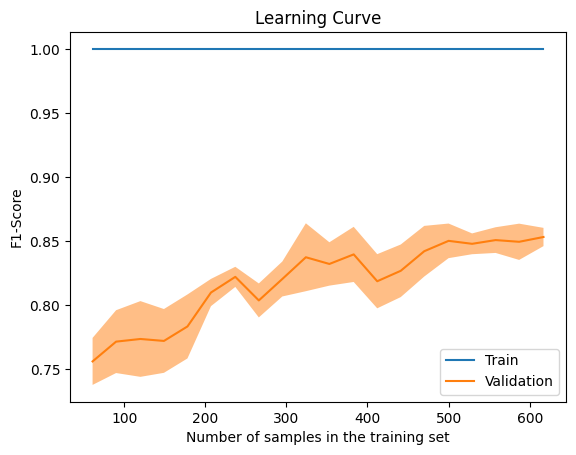

In [10]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=x_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1, 20),  # 10 punti di addestramento
    cv=5,
    scoring='f1',
    n_jobs=4
)

display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=val_scores, score_name="F1-Score")
display.plot()
plt.title("Learning Curve")
plt.legend(["Train", "Validation"])
plt.show()

<h3>ROC AUC Curve</h3>

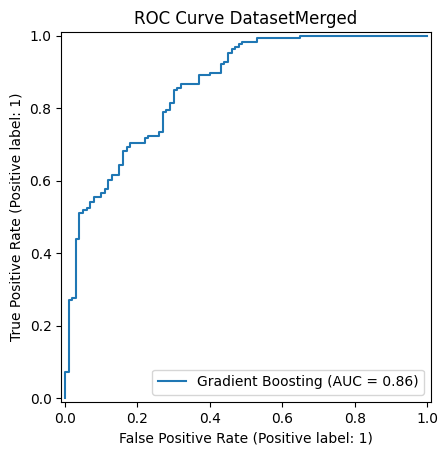

In [11]:
ax = plt.gca()
ax.set_title('ROC Curve DatasetMerged')

svc_disp = RocCurveDisplay.from_estimator(best_model, x_test, y_test, name="Gradient Boosting", ax=ax)

plt.show()

<h3>Confusion Matrices</h3>

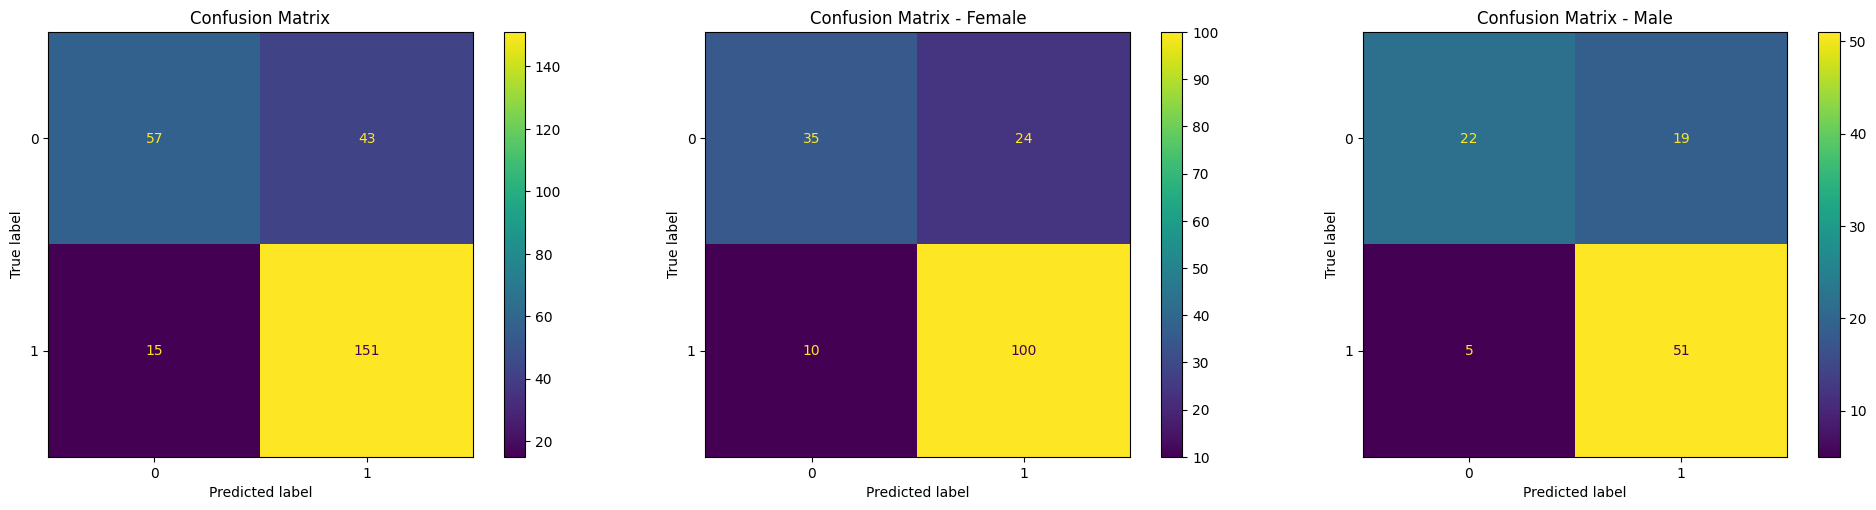

In [25]:
current = dataset.copy()
current['Gender'] = joblib.load('genderFull.pkl')
current[current['Gender'] == 'Female']

currentTest = pd.merge(current[['SampleID', 'Gender']], test, on='SampleID', how='right')

currentTest['Gender'] = currentTest['Gender'].apply(lambda x: 0 if x == 'female' or x == 'Female' else 1)

female_test = currentTest[currentTest['Gender'] == 0]
df = female_test.copy()

male_test = currentTest[currentTest['Gender'] == 1]
df_male = male_test.copy()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ConfusionMatrixDisplay.from_estimator(best_model, x_test, y_test, ax=axes[0])
axes[0].set_title("Confusion Matrix")

ConfusionMatrixDisplay.from_estimator(best_model, df.drop(columns=['SampleID', 'Label', 'PatientID', 'Gender']), female_test['Label'], ax=axes[1])
axes[1].set_title("Confusion Matrix - Female")

ConfusionMatrixDisplay.from_estimator(best_model, df_male.drop(columns=['SampleID', 'Label', 'PatientID', 'Gender']),  male_test['Label'],  ax=axes[2])
axes[2].set_title("Confusion Matrix - Male")

plt.tight_layout()
plt.show()